<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/36_S%2BP_Week_3_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

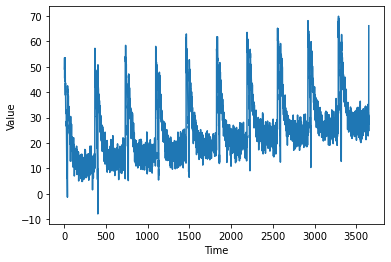

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None) :
  plt.plot(time[start : end], series[start : end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(False)

def trend(time, slope = 0) :
  return slope * time

def seasonal_pattern(season_time) :
  return np.where(season_time < 0.1,
                  np.cos(season_time * 6 * np.pi),
                  2 / np.exp(9 * season_time))
  
def seasonality(time, period, amplitude = 1, phase = 0) :
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None) :
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.005
noise_level = 3

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
series += noise(time, noise_level, seed = 51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer) :
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window : (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [4]:
from tensorflow.keras.layers import Lambda, LSTM, Bidirectional, Dense

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis = -1),
                           input_shape = [None]),
    Bidirectional(LSTM(32, return_sequences = True)),
    Bidirectional(LSTM(32)),
    Dense(1),
    Lambda(lambda x : x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule], verbose = 0)

(1e-08, 0.0001, 0.0, 30.0)

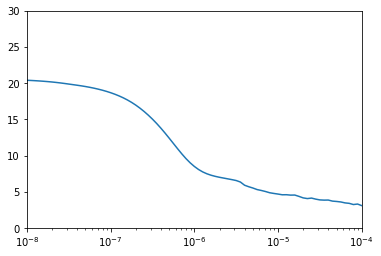

In [5]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis = -1),
           input_shape = [None]),
    Bidirectional(LSTM(32, return_sequences = True)),
    Bidirectional(LSTM(32)),
    Dense(1),
    Lambda(lambda x: x * 100.0)
])

model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(dataset, epochs = 500, verbose = 1)

Epoch 1/500
94/94 [==============================] - 5s 10ms/step - loss: 621.4117 - mae: 17.3185
Epoch 2/500
94/94 [==============================] - 1s 10ms/step - loss: 35.4448 - mae: 3.9949
Epoch 3/500
94/94 [==============================] - 1s 11ms/step - loss: 24.7060 - mae: 3.3967
Epoch 4/500
94/94 [==============================] - 1s 10ms/step - loss: 27.9482 - mae: 3.7105
Epoch 5/500
94/94 [==============================] - 1s 11ms/step - loss: 25.3553 - mae: 3.5254
Epoch 6/500
94/94 [==============================] - 1s 11ms/step - loss: 23.1941 - mae: 3.3501
Epoch 7/500
94/94 [==============================] - 1s 9ms/step - loss: 29.9593 - mae: 3.9666
Epoch 8/500
94/94 [==============================] - 1s 10ms/step - loss: 27.3687 - mae: 3.7184
Epoch 9/500
94/94 [==============================] - 1s 10ms/step - loss: 22.7929 - mae: 3.4158
Epoch 10/500
94/94 [==============================] - 1s 10ms/step - loss: 24.3467 - mae: 3.4988
Epoch 11/500
94/94 [==================

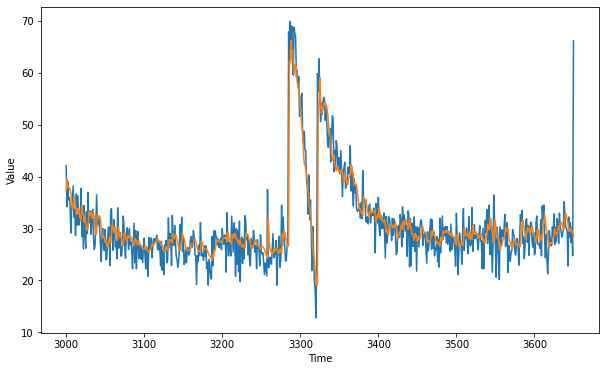

In [8]:
forecast = []
results = []

for time in range(len(series) - window_size) :
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9205341

<Figure size 432x288 with 0 Axes>

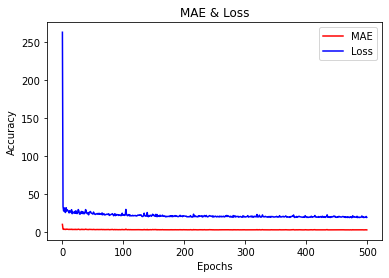

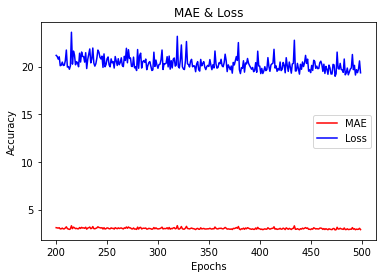

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE & Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE & Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])
plt.figure()